In [ ]:
! pip install evaluate -qq
! pip install korouge_score -qq
! pip install bert_score -qq

In [ ]:
from datasets import load_dataset, Dataset, DatasetDict
import pandas as pd
import json
import os
import zipfile
from typing import List, Dict

def flatten_json_data(data_list):
    """JSON 데이터를 평탄화하는 함수"""
    return pd.json_normalize(
        data_list,
        sep='_',
        record_path=None,
        meta=[
            'category',
            'job_field',
            'gender',
            'experience',
            ['version'],
            ['dataSet', 'answer', 'raw', 'text'],
            ['dataSet', 'answer', 'summary', 'text'],
            ['dataSet', 'question', 'raw', 'text'],
            ['dataSet', 'info', 'ageRange'],
            ['dataSet', 'info', 'channel'],
            ['dataSet', 'info', 'date'],
            ['dataSet', 'info', 'experience'],
            ['dataSet', 'info', 'gender'],
            ['dataSet', 'info', 'occupation'],
            ['dataSet', 'info', 'place'],
            ['rawDataInfo', 'answer', 'audioPath'],
            ['rawDataInfo', 'question', 'audioPath']
        ]
    )

def download_and_extract(urls: List[str], base_path: str) -> None:
    """
    URL 리스트에서 ZIP 파일을 다운로드하고 압축을 해제하는 함수
    """
    os.makedirs(base_path, exist_ok=True)

    for i, url in enumerate(urls):
        zip_file_name = url.split("/")[-1]
        zip_file_path = os.path.join("/kaggle/working", zip_file_name)
        print(f'처리중... {i+1}: {zip_file_name}')

        # wget을 사용하여 파일 다운로드
        !wget -q {url} -O {zip_file_path}

        # 압축 해제할 폴더 생성
        subfolder_name = zip_file_name.replace('.zip', '')
        subfolder_path = os.path.join(base_path, subfolder_name)
        os.makedirs(subfolder_path, exist_ok=True)

        # ZIP 파일 압축 해제
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(subfolder_path)

        # 다운로드한 ZIP 파일 삭제
        os.remove(zip_file_path)

def create_dataset_from_json_files(base_path: str) -> Dataset:
    """
    주어진 경로에서 JSON 파일들을 읽어 Dataset으로 변환하는 함수
    """
    all_data = []

    for root, _, files in os.walk(base_path):
        for file in files:
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        data = json.load(f)
                        # 파일 경로에서 메타데이터 추출
                        folder_name = os.path.basename(os.path.dirname(file_path))
                        parts = folder_name.split('_')
                        data.update({
                            'category': parts[0],  # TL or VL
                            'job_field': '_'.join(parts[1:-2]),
                            'gender': parts[-2],
                            'experience': parts[-1]
                        })
                        all_data.append(data)
                except json.JSONDecodeError as e:
                    print(f"Error reading {file_path}: {e}")

    # JSON 데이터 평탄화
    df = flatten_json_data(all_data)

    # DataFrame을 Dataset으로 변환
    return Dataset.from_pandas(df)

def create_interview_dataset():
    """
    인터뷰 데이터셋을 생성하고 DatasetDict로 반환하는 함수
    """
    # 훈련 데이터 URL
    train_urls = [
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_01.Management_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_01.Management_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_01.Management_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_01.Management_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_02.SalesMarketing_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_02.SalesMarketing_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_02.SalesMarketing_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_02.SalesMarketing_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_03.PublicService_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_03.PublicService_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_03.PublicService_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_03.PublicService_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_04.RND_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_04.RND_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_04.RND_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_04.RND_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_05.ICT_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_05.ICT_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_05.ICT_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_05.ICT_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_06.Design_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_06.Design_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_06.Design_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_06.Design_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_07.ProductionManufacturing_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_07.ProductionManufacturing_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_07.ProductionManufacturing_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_07.ProductionManufacturing_Male_New.zip"
    ]

    # 검증 데이터 URL
    valid_urls = [
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_01.Management_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_01.Management_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_01.Management_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_01.Management_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_02.SalesMarketing_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_02.SalesMarketing_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_02.SalesMarketing_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_02.SalesMarketing_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_03.PublicService_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_03.PublicService_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_03.PublicService_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_03.PublicService_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_04.RND_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_04.RND_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_04.RND_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_04.RND_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_05.ICT_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_05.ICT_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_05.ICT_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_05.ICT_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_06.Design_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_06.Design_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_06.Design_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_06.Design_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_07.ProductionManufacturing_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_07.ProductionManufacturing_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_07.ProductionManufacturing_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_07.ProductionManufacturing_Male_New.zip"
    ]

    # 데이터 다운로드 및 압축 해제
    train_path = '/kaggle/working/train_unzipped'
    valid_path = '/kaggle/working/validation_unzipped'

    download_and_extract(train_urls, train_path)
    download_and_extract(valid_urls, valid_path)

    # 데이터셋 생성
    train_dataset = create_dataset_from_json_files(train_path)
    valid_dataset = create_dataset_from_json_files(valid_path)

    # DatasetDict 생성
    dataset_dict = DatasetDict({
        'train': train_dataset,
        'validation': valid_dataset
    })

    return dataset_dict

# Data Preprocessing

In [ ]:
# 데이터셋 생성
dataset = create_interview_dataset()

# 데이터셋 정보 출력
print("\nDataset Info:")
print(dataset)

# 훈련 데이터 샘플 확인
print("\nTraining Data Sample:")
print(dataset['train'][0])

# 검증 데이터 샘플 확인
print("\nValidation Data Sample:")
print(dataset['validation'][0])

처리중... 1: TL_01.Management_Female_Experienced.zip
처리중... 2: TL_01.Management_Female_New.zip
처리중... 3: TL_01.Management_Male_Experienced.zip
처리중... 4: TL_01.Management_Male_New.zip
처리중... 5: TL_02.SalesMarketing_Female_Experienced.zip
처리중... 6: TL_02.SalesMarketing_Female_New.zip
처리중... 7: TL_02.SalesMarketing_Male_Experienced.zip
처리중... 8: TL_02.SalesMarketing_Male_New.zip
처리중... 9: TL_03.PublicService_Female_Experienced.zip
처리중... 10: TL_03.PublicService_Female_New.zip
처리중... 11: TL_03.PublicService_Male_Experienced.zip
처리중... 12: TL_03.PublicService_Male_New.zip
처리중... 13: TL_04.RND_Female_Experienced.zip
처리중... 14: TL_04.RND_Female_New.zip
처리중... 15: TL_04.RND_Male_Experienced.zip
처리중... 16: TL_04.RND_Male_New.zip
처리중... 17: TL_05.ICT_Female_Experienced.zip
처리중... 18: TL_05.ICT_Female_New.zip
처리중... 19: TL_05.ICT_Male_Experienced.zip
처리중... 20: TL_05.ICT_Male_New.zip
처리중... 21: TL_06.Design_Female_Experienced.zip
처리중... 22: TL_06.Design_Female_New.zip
처리중... 23: TL_06.Design_Male_Ex

In [ ]:
from transformers import PreTrainedTokenizerFast
from transformers import GPT2LMHeadModel
import torch


In [ ]:
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
bos_token='</s>', eos_token='</s>', unk_token='<unk>',
pad_token='<pad>', mask_token='<mask>')

tokenizer.json:   0%|          | 0.00/2.83M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
occupation_map = {
    'SM': '영업마케팅',
    'PS': '공공서비스',
    'RND': '연구개발',
    'ICT': '정보통신',
    'ARD': '디자인',
    'MM': '생산관리',
    'BM': '경영사무'
}
def preprocess_training_examples(examples):
    max_length=256
    formatted_inputs = [
        f"</s> 직무: {occupation_map[occ]} 경력상태: {'신입' if exp == 'NEW' else '경력직'} 질문: {q} 답변: {a} </s>"
        for occ, exp, q, a in zip(
            examples["dataSet_info_occupation"],
            examples["dataSet_info_experience"],
            examples["dataSet_question_raw_text"],
            examples["dataSet_answer_raw_text"]
        )
    ]

    tokenized = tokenizer(
        formatted_inputs,
        max_length=max_length,
        truncation=True,
        padding="max_length"
    )

    return {
        'input_ids': tokenized['input_ids'],
        'attention_mask': tokenized['attention_mask'],
        'labels': [-100 if token == tokenizer.pad_token_id else token for token in tokenized['input_ids']]
    }

orig_train_dataset = dataset['train'].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=dataset['train'].column_names,
    load_from_cache_file=False  # 이 옵션 추가
)

orig_valid_dataset = dataset['validation'].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=dataset['validation'].column_names,
    load_from_cache_file=False  # 이 옵션 추가
)

Map:   0%|          | 0/68074 [00:00<?, ? examples/s]

Map:   0%|          | 0/8026 [00:00<?, ? examples/s]

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
from torch.utils.data import Subset

train_dataset = orig_train_dataset
valid_dataset = orig_valid_dataset
# # 앞에서부터 1000개씩 선택
# train_dataset = Subset(orig_train_dataset, range(100))
# valid_dataset = Subset(orig_valid_dataset, range(100))

print(len(valid_dataset))  # 1000

8026


In [ ]:
def collate_fn(batch):
   input_ids = torch.stack([torch.tensor(item['input_ids']) for item in batch])
   attention_mask = torch.stack([torch.tensor(item['attention_mask']) for item in batch])
   labels = torch.stack([torch.tensor(item['labels']) for item in batch])

   return {
       'input_ids': input_ids,
       'attention_mask': attention_mask,
       'labels': labels
   }

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

# DataLoader에서 배치 샘플 확인
for batch in train_dataloader:
    print("Input IDs shape:", batch['input_ids'].shape)
    print("Attention mask shape:", batch['attention_mask'].shape)
    print("Labels shape:", batch['labels'].shape)
    for i in batch['input_ids']:
        print(i)
        print(tokenizer.decode(i))
        break

    break

Input IDs shape: torch.Size([16, 256])
Attention mask shape: torch.Size([16, 256])
Labels shape: torch.Size([16, 256])
tensor([    1, 17141,   401, 11599, 16371, 12170, 11626,   401, 12170,  8264,
        24454,   401,  9105, 32617,  9230,  8539, 38289, 38604, 11018,  8705,
         9025, 10566, 29735,  9098, 35795, 11011,  8159,  7177, 43057,  9863,
        13091, 32075, 13358,  8133,  7890,  6824,  8084,  9394,  9022, 13091,
        32075, 13358,  8133,  7890, 10175,  7235,  9304, 24117,  8711, 36658,
         6962,  9117,  7377,  7172,  7182, 12817,  7643,   401,  9024, 14116,
         9230,  8539, 38289,  9659, 11018,  8705,  9025, 21159,  9863,  9290,
        32075, 22386,  8263,  9050, 10175,  7235, 24117,  8711, 29266,  9078,
         7816,  9668, 25856,  9265,  7162, 45887, 24107, 16210,  9080,  9362,
         9877, 13079, 14135, 14633,  9466, 25856,  9174, 40604,  9721,  9230,
         8539,  7293, 21154, 15063,  9265,  7162, 14135, 14633,  9230,  8539,
        38289, 13185, 2

In [ ]:
import torch
from transformers import GPT2LMHeadModel

model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

pytorch_model.bin:   0%|          | 0.00/513M [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=51200, bias=False)
)

## Model Train

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from korouge_score import rouge_scorer
from tqdm import tqdm
from bert_score import score  # bert-score import 추가

In [ ]:
# SmoothingFunction 설정
smoothing = SmoothingFunction().method1

# 모델 학습 설정
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 옵티마이저 및 스케줄러 정의
optimizer = AdamW(model.parameters(), lr=5e-5)  # 옵티마이저 정의
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)  # 스케줄러 정의

# ROUGE 계산기
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
best_valid_loss = float('inf')

# 학습 및 검증 루프
for epoch in range(num_epochs):
    # 학습 단계
    model.train()
    total_train_loss = 0
    train_steps = 0
    total_train_bleu = 0
    total_train_rouge = {'rouge1': 0, 'rouge2': 0, 'rougeL': 0}
    num_train_samples = 0

    train_pbar = tqdm(train_dataloader, desc=f'Training Epoch {epoch+1}')
    for batch in train_pbar:
        # 입력 데이터 준비
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # 모델 출력
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # 역전파 및 최적화
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()  # 옵티마이저 업데이트
        scheduler.step()  # 스케줄러 업데이트
        optimizer.zero_grad()
        torch.cuda.empty_cache()  # 여기 추가

        # 손실 누적
        total_train_loss += loss.item()
        train_steps += 1

        train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    # 평균 점수 계산
    avg_train_loss = total_train_loss / train_steps

    print(f"\nEpoch {epoch+1} Average Training Loss: {avg_train_loss:.4f}")

    # 검증 단계
    model.eval()
    total_valid_loss = 0
    valid_steps = 0
    total_valid_bleu = 0
    total_valid_rouge = {'rouge1': 0, 'rouge2': 0, 'rougeL': 0}
    num_valid_samples = 0

    all_generated_texts = []  # BERTScore를 계산하기 위한 생성 텍스트 리스트
    all_reference_texts = []  # BERTScore를 계산하기 위한 참조 텍스트 리스트

    with torch.no_grad():
        valid_pbar = tqdm(valid_dataloader, desc=f'Validation Epoch {epoch+1}')
        for i, batch in enumerate(valid_pbar):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            # 손실 누적
            total_valid_loss += loss.item()
            valid_steps += 1

            # BLEU 및 ROUGE 계산
            generated_ids = outputs.logits.argmax(dim=-1)
            generated_texts = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
            labels_for_decoding = labels.masked_fill(labels == -100, tokenizer.pad_token_id)
            reference_texts = tokenizer.batch_decode(labels_for_decoding, skip_special_tokens=True)
            if i ==0:
                for r,g in zip(reference_texts,generated_texts):
                    print(r)
                    print(g)

            all_generated_texts.extend(generated_texts)
            all_reference_texts.extend(reference_texts)

            for ref, gen in zip(reference_texts, generated_texts):
                bleu_score = sentence_bleu([ref.split()], gen.split(), smoothing_function=smoothing)
                total_valid_bleu += bleu_score

                rouge_scores = scorer.score(ref, gen)
                for key in total_valid_rouge.keys():
                    total_valid_rouge[key] += rouge_scores[key].fmeasure
                num_valid_samples +=1

            valid_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
            torch.cuda.empty_cache()  # 여기 추가

    # 평균 점수 계산
    avg_valid_loss = total_valid_loss / valid_steps
    avg_valid_bleu = total_valid_bleu / valid_steps
    avg_valid_rouge = {k: v / num_valid_samples for k, v in total_valid_rouge.items()}

    # BERTScore 계산
    P, R, F1 = score(all_generated_texts, all_reference_texts, lang="ko", verbose=True)  # lang="ko"는 한국어 기준

    print(f"Epoch {epoch+1} Average Validation Loss: {avg_valid_loss:.4f}")
    print(f"Epoch {epoch+1} Average Validation BLEU: {avg_valid_bleu:.4f}")
    print(f"Epoch {epoch+1} Average Validation ROUGE: {avg_valid_rouge}")
    print(f"Epoch {epoch+1} BERTScore Precision: {P.mean():.4f}")
    print(f"Epoch {epoch+1} BERTScore Recall: {R.mean():.4f}")
    print(f"Epoch {epoch+1} BERTScore F1: {F1.mean():.4f}")

    # 최적의 모델 저장
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        print(f"Saving best model with validation loss: {best_valid_loss:.4f}")
        torch.save(model.state_dict(), './best_model.pt')  # 현재 디렉토리에 저장

print("\nTraining completed!")


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1: 100%|██████████| 4255/4255 [1:34:57<00:00,  1.34s/it, loss=2.2281]



Epoch 1 Average Training Loss: 2.3968


Validation Epoch 1:   0%|          | 1/502 [00:00<04:39,  1.79it/s, loss=2.3902]

직무: 디자인 경력상태: 경력직 질문: 타 부서와 갈등 상황이 생겼을 때 어떻게 해결하겠는가요 답변: 음 타 부서와 갈등 상황이 생겼을 때 어떻게 해결하겠는가 라고 말씀해주셨는데요. 살다 보면 우리가 부딪치지 않는 일은 없을 것 같습니다. 항상 부딪치고 해결하고 또 살아가고 또 부딪치고 해결하고 또 살아가고 하는 것들이 이 인생인 것 같고 삶인데 타 부서와 갈등 상황이 생겼을 때는 일단 어떤 것이 잘잘못인가를 일단은 어 판단을 해야 될 것이고 그리고 내가 잘못한 일이 있다라면 정중하게 사과하고 미안하다 하고 미안하다 라고 하고 그리고 금방 화해를 할 것 같습니다 .하지만 상대방이 잘못된 일이 있다라고 하면 꼭 그것은 그 이해를 시키고 납득을 시키고 그리고 잘못된 부분은 이런 이렇게 잘못된 부분은 고쳐 나갈 수 있는 거 바꿔 나갈 수 있는 거 이런 거를 유도하고 그래서 그렇게 할 것 같습니다. 그 잘 뭐든지 잘 해결하고 그렇게 살 살아 갑니다 제 성격이. 감사합니다. 
직무: 경영 경력상태: 신입직 질문: 지원인이서와 갈등 상황이 발생 때 어떻게 해결하습니까요 상황을변: 타 타 부서와 갈등이 상황이 생겼을 때 저 해결하냐 라고 질문을을신는데요. 어 보면은 어떤치는 않는 부분이 없을 것 같습니다. 어 부딪치는 부딪해야 부딪 부딪면서 있는 부딪치는 또하고 하는 부딪다 하는 과정에서 다게에서 것 같요.인 그런 부서와 갈등이 상황이 생겼을 때 어 그 문제가 문제 해결못인지 먼저단은 파악 먼저 해야 될 것요. 그 이한 부분이 있다면 라고 어하게 사하고 또안하다 라고 또안하다 하고 하는 또 그방 사해를 할 것 같습니다.다 라고그리고 그 잘못 부분이 있다 라고 하면 그 사 고쳐 사람의 해야고 또득을 시켜고 또 그 부분이 어 식으로 고쳐 부분을 고쳐 나가 수 있도록 그런라고 나가 수 있는 그런를 것들을를 먼저할 또 그 해결 것 같습니다. 게잘 잘못 잘 해결하고 또 해서 수왔니다.다 라고 생각. 합니다. 
직무: 디자인 경력상태: 경력직 질문: 지금까지 인생을 살면서 가장 후회

Validation Epoch 1: 100%|██████████| 502/502 [04:19<00:00,  1.93it/s, loss=2.3751]


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

calculating scores...
computing bert embedding.


  0%|          | 0/251 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/126 [00:00<?, ?it/s]

done in 294.12 seconds, 27.29 sentences/sec
Epoch 1 Average Validation Loss: 2.1848
Epoch 1 Average Validation BLEU: 0.9907
Epoch 1 Average Validation ROUGE: {'rouge1': 0.36113226537367676, 'rouge2': 0.10655334916276298, 'rougeL': 0.28845259678907886}
Epoch 1 BERTScore Precision: 0.7849
Epoch 1 BERTScore Recall: 0.7743
Epoch 1 BERTScore F1: 0.7795
Saving best model with validation loss: 2.1848


Training Epoch 2: 100%|██████████| 4255/4255 [1:36:02<00:00,  1.35s/it, loss=2.2212]



Epoch 2 Average Training Loss: 2.2046


Validation Epoch 2:   0%|          | 1/502 [00:00<04:37,  1.81it/s, loss=2.3562]

직무: 디자인 경력상태: 경력직 질문: 타 부서와 갈등 상황이 생겼을 때 어떻게 해결하겠는가요 답변: 음 타 부서와 갈등 상황이 생겼을 때 어떻게 해결하겠는가 라고 말씀해주셨는데요. 살다 보면 우리가 부딪치지 않는 일은 없을 것 같습니다. 항상 부딪치고 해결하고 또 살아가고 또 부딪치고 해결하고 또 살아가고 하는 것들이 이 인생인 것 같고 삶인데 타 부서와 갈등 상황이 생겼을 때는 일단 어떤 것이 잘잘못인가를 일단은 어 판단을 해야 될 것이고 그리고 내가 잘못한 일이 있다라면 정중하게 사과하고 미안하다 하고 미안하다 라고 하고 그리고 금방 화해를 할 것 같습니다 .하지만 상대방이 잘못된 일이 있다라고 하면 꼭 그것은 그 이해를 시키고 납득을 시키고 그리고 잘못된 부분은 이런 이렇게 잘못된 부분은 고쳐 나갈 수 있는 거 바꿔 나갈 수 있는 거 이런 거를 유도하고 그래서 그렇게 할 것 같습니다. 그 잘 뭐든지 잘 해결하고 그렇게 살 살아 갑니다 제 성격이. 감사합니다. 
직무: 공공 경력상태: 신입직 질문: 지원인이서와 갈등 상황이 발생 때 어떻게 해결하습니까요 상황을변: 네 타 부서와 갈등 상황이 생겼을 때 저 해결하냐 라고 질문을을셨는데요. 어 보면은 서로치는 않는 일 없 것 같습니다. 왜냐하면 부딪치는 부딪해야 부딪 해결다 있는데 그런치는 또하고 이런 부딪다 있는데 그런 있는데 부에서 것 같요.인요. 부서와 갈등 상황이 생겼을 때 어 그 문제가 문제 해결못인지 먼저단은 파악 먼저 해야 될 것요. 그 잘못한 것이 있다면 라고 그하게 사하고 또안하다 라고 사과안하다 하고 하는 또 또방 사해를 해야 것 같습니다.다 라고그리고 그 잘못 일이 있다 라고 하면 그 사 사 부 해야고 또득을 시켜고 또 그 일이 어 식으로 해결을 부분을 이렇게서 수 있도록 그런를 나가 수 있는 거를 것들을를 좀해서 또 그 해결을 것 같습니다. 게잘 잘못 잘 해결하고 또 해서면왔니다.다 라고 인생. 합니다. 
직무: 디자인 경력상태: 경력직 질문: 지금까지 인생을 살면서 가장 후회되는 일이 

Validation Epoch 2: 100%|██████████| 502/502 [04:19<00:00,  1.93it/s, loss=2.3250]


calculating scores...
computing bert embedding.


  0%|          | 0/251 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/126 [00:00<?, ?it/s]

done in 295.05 seconds, 27.20 sentences/sec
Epoch 2 Average Validation Loss: 2.1438
Epoch 2 Average Validation BLEU: 1.0808
Epoch 2 Average Validation ROUGE: {'rouge1': 0.36888556371655756, 'rouge2': 0.11201027214611432, 'rougeL': 0.29523582738445275}
Epoch 2 BERTScore Precision: 0.7868
Epoch 2 BERTScore Recall: 0.7764
Epoch 2 BERTScore F1: 0.7816
Saving best model with validation loss: 2.1438


Training Epoch 3: 100%|██████████| 4255/4255 [1:35:32<00:00,  1.35s/it, loss=2.0134]



Epoch 3 Average Training Loss: 2.1004


Validation Epoch 3:   0%|          | 1/502 [00:00<04:48,  1.74it/s, loss=2.3334]

직무: 디자인 경력상태: 경력직 질문: 타 부서와 갈등 상황이 생겼을 때 어떻게 해결하겠는가요 답변: 음 타 부서와 갈등 상황이 생겼을 때 어떻게 해결하겠는가 라고 말씀해주셨는데요. 살다 보면 우리가 부딪치지 않는 일은 없을 것 같습니다. 항상 부딪치고 해결하고 또 살아가고 또 부딪치고 해결하고 또 살아가고 하는 것들이 이 인생인 것 같고 삶인데 타 부서와 갈등 상황이 생겼을 때는 일단 어떤 것이 잘잘못인가를 일단은 어 판단을 해야 될 것이고 그리고 내가 잘못한 일이 있다라면 정중하게 사과하고 미안하다 하고 미안하다 라고 하고 그리고 금방 화해를 할 것 같습니다 .하지만 상대방이 잘못된 일이 있다라고 하면 꼭 그것은 그 이해를 시키고 납득을 시키고 그리고 잘못된 부분은 이런 이렇게 잘못된 부분은 고쳐 나갈 수 있는 거 바꿔 나갈 수 있는 거 이런 거를 유도하고 그래서 그렇게 할 것 같습니다. 그 잘 뭐든지 잘 해결하고 그렇게 살 살아 갑니다 제 성격이. 감사합니다. 
직무: 공공 경력상태: 신입직 질문: 지원 부서와 갈등 상황이 발생 때 어떻게 해결하습니까요 상황을변: 네 타 부서와 갈등 상황이 생긴 때 어 해결하겠냐 라고 질문을을셨는데요. 어 보면은 갈등치는 않는 일이 없 거 같습니다. 왜냐하면 부딪치는 부딪해야 부딪 부딪야 있는데 부딪치는 또하고 이런 부딪고 있는데 그런 있는데게에서 것 같요.인요. 부서와 갈등 상황이 생긴 때 어 그 부분이 가장 풀못인지 먼저단은 잘 따져 해야 될 것요. 그 잘못한 것이 있다면 라고 어하게 사하고 어안하다 라고 사안하다 하고 하는 어 어방 해결해를 하고 것 같습니다.다 라고그리고 그 잘못 부분이 있다면 라고 하면 그 사 사 사람의 하고고 또득을 시키고 또 그 것이 어 식으로 해결해 부분을 이렇게서 수 있도록 그런를 나갈 수 있는 거를 것들을를 먼저해서 또 그 해결을 것 같습니다. 게잘 잘 잘 해결하고 또 해서면왔니다.다 라고 인생. 합니다. 
직무: 디자인 경력상태: 경력직 질문: 지금까지 인생을 살면서 가장 후회되는 일이

Validation Epoch 3: 100%|██████████| 502/502 [04:47<00:00,  1.75it/s, loss=2.3076]


calculating scores...
computing bert embedding.


  0%|          | 0/251 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/126 [00:00<?, ?it/s]

done in 303.20 seconds, 26.47 sentences/sec
Epoch 3 Average Validation Loss: 2.1272
Epoch 3 Average Validation BLEU: 1.0979
Epoch 3 Average Validation ROUGE: {'rouge1': 0.3685831537012728, 'rouge2': 0.11308935924333709, 'rougeL': 0.29737097199500273}
Epoch 3 BERTScore Precision: 0.7864
Epoch 3 BERTScore Recall: 0.7769
Epoch 3 BERTScore F1: 0.7816
Saving best model with validation loss: 2.1272


Training Epoch 4: 100%|██████████| 4255/4255 [1:35:10<00:00,  1.34s/it, loss=1.8359]



Epoch 4 Average Training Loss: 2.0221


Validation Epoch 4:   0%|          | 1/502 [00:00<04:28,  1.86it/s, loss=2.3285]

직무: 디자인 경력상태: 경력직 질문: 타 부서와 갈등 상황이 생겼을 때 어떻게 해결하겠는가요 답변: 음 타 부서와 갈등 상황이 생겼을 때 어떻게 해결하겠는가 라고 말씀해주셨는데요. 살다 보면 우리가 부딪치지 않는 일은 없을 것 같습니다. 항상 부딪치고 해결하고 또 살아가고 또 부딪치고 해결하고 또 살아가고 하는 것들이 이 인생인 것 같고 삶인데 타 부서와 갈등 상황이 생겼을 때는 일단 어떤 것이 잘잘못인가를 일단은 어 판단을 해야 될 것이고 그리고 내가 잘못한 일이 있다라면 정중하게 사과하고 미안하다 하고 미안하다 라고 하고 그리고 금방 화해를 할 것 같습니다 .하지만 상대방이 잘못된 일이 있다라고 하면 꼭 그것은 그 이해를 시키고 납득을 시키고 그리고 잘못된 부분은 이런 이렇게 잘못된 부분은 고쳐 나갈 수 있는 거 바꿔 나갈 수 있는 거 이런 거를 유도하고 그래서 그렇게 할 것 같습니다. 그 잘 뭐든지 잘 해결하고 그렇게 살 살아 갑니다 제 성격이. 감사합니다. 
직무: 공공 경력상태: 신입직 질문: 지원 지원서와 갈등 상황이 발생 때 어떻게 해결하습니까요 상황을변: 네 타 부서와 갈등 상황이 생겼을 때 저 해결하겠냐 라고 질문을을셨는데 음 어 보면은 갈등치는 않는 일 없 거 같습니다. 왜냐하면 부딪치는 부딪해야 부딪 부딪야 있는데 부딪치는 또하고 이런 부딪고 있는데 것들이 있는데게에서 것 같요.인요. 부서와 갈등 상황이 생겼을 때 어 그 부분에서 문제 해결못인지 먼저단은 파악 따져 해야 될 것요. 그 잘못한 것이 있다면 라고 그하게 사하고 그리고안하다 라고 사안하다 하고 하는 사 그방 다시해를 할 것 같습니다.다 라고그리고 그 잘못 부분이 있다면 라고 하면 그 사 사 사람의 하고고 또득을 시키고 또 그 것이 다시 식으로 해결해 부분을 이렇게 나가 수 있도록 그런를 나가 수 있는 거를 것들을를 먼저해서 그리고 그 해결을 것 같습니다. 게잘 잘못 잘 해결하고 또 해서면왔니다.다 라고 생각. 합니다. 
직무: 디자인 경력상태: 경력직 질문: 지금까지 인생을 살

Validation Epoch 4: 100%|██████████| 502/502 [04:20<00:00,  1.93it/s, loss=2.2940]


calculating scores...
computing bert embedding.


  0%|          | 0/251 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/126 [00:00<?, ?it/s]

done in 319.90 seconds, 25.09 sentences/sec
Epoch 4 Average Validation Loss: 2.1161
Epoch 4 Average Validation BLEU: 1.1363
Epoch 4 Average Validation ROUGE: {'rouge1': 0.3733726912575121, 'rouge2': 0.11597023654426206, 'rougeL': 0.3004440518497631}
Epoch 4 BERTScore Precision: 0.7888
Epoch 4 BERTScore Recall: 0.7800
Epoch 4 BERTScore F1: 0.7843
Saving best model with validation loss: 2.1161


Training Epoch 5: 100%|██████████| 4255/4255 [1:36:06<00:00,  1.36s/it, loss=1.5819]



Epoch 5 Average Training Loss: 1.9635


Validation Epoch 5:   0%|          | 1/502 [00:00<04:25,  1.89it/s, loss=2.3255]

직무: 디자인 경력상태: 경력직 질문: 타 부서와 갈등 상황이 생겼을 때 어떻게 해결하겠는가요 답변: 음 타 부서와 갈등 상황이 생겼을 때 어떻게 해결하겠는가 라고 말씀해주셨는데요. 살다 보면 우리가 부딪치지 않는 일은 없을 것 같습니다. 항상 부딪치고 해결하고 또 살아가고 또 부딪치고 해결하고 또 살아가고 하는 것들이 이 인생인 것 같고 삶인데 타 부서와 갈등 상황이 생겼을 때는 일단 어떤 것이 잘잘못인가를 일단은 어 판단을 해야 될 것이고 그리고 내가 잘못한 일이 있다라면 정중하게 사과하고 미안하다 하고 미안하다 라고 하고 그리고 금방 화해를 할 것 같습니다 .하지만 상대방이 잘못된 일이 있다라고 하면 꼭 그것은 그 이해를 시키고 납득을 시키고 그리고 잘못된 부분은 이런 이렇게 잘못된 부분은 고쳐 나갈 수 있는 거 바꿔 나갈 수 있는 거 이런 거를 유도하고 그래서 그렇게 할 것 같습니다. 그 잘 뭐든지 잘 해결하고 그렇게 살 살아 갑니다 제 성격이. 감사합니다. 
직무: 공공 경력상태: 신입직 질문: 지원인이서와 갈등 상황이 발생 때 어떻게 해결하습니까요 상황을변: 네 타 부서와 갈등 상황이 생겼을 때 저 해결하겠냐 라고 물어을신는데요. 어 보면은 갈등치는 않는 일 없 거 같습니다. 왜냐하면 부딪치는 부딪해야 부딪 부딪야 있는데 부딪치고 또하고 이런 부딪고 있는데 게 있는데게에서 것 같요.인요. 부서와 갈등 상황이 생겼을 때 어 그 부분에서 문제 해결못인지 먼저단은 파악 파악 해야 될 것요. 그 잘못한 것이 있다면 라고 그하게 사하고 어안하다 라고 사안하다 하고 하는 어 내가방 사해를 해야 것 같습니다.다 라고그리고 그 잘못 부분이 있다면 라고 하면 그 사 사 사람의 하고고 또득을 시키고 또 그 것이 어 식으로 해결해 부분을 이렇게 나가 수 있도록 그런를 나가 수 있는 거를 것들을를 먼저해서 설득 그 해결을 것 같습니다. 게잘 잘못 잘 해결하고 잘 해서면왔니다.다 라고 인생. 합니다. 
직무: 디자인 경력상태: 경력직 질문: 지금까지 인생을 살면서 가장 후

Validation Epoch 5: 100%|██████████| 502/502 [04:20<00:00,  1.93it/s, loss=2.2979]


calculating scores...
computing bert embedding.


  0%|          | 0/251 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/126 [00:00<?, ?it/s]

done in 294.96 seconds, 27.21 sentences/sec
Epoch 5 Average Validation Loss: 2.1141
Epoch 5 Average Validation BLEU: 1.1472
Epoch 5 Average Validation ROUGE: {'rouge1': 0.37426584343034, 'rouge2': 0.1165167686302273, 'rougeL': 0.3008576294358529}
Epoch 5 BERTScore Precision: 0.7888
Epoch 5 BERTScore Recall: 0.7806
Epoch 5 BERTScore F1: 0.7847
Saving best model with validation loss: 2.1141

Training completed!


In [ ]:
import torch
import gc

# GPU 상태 초기화 및 남은 메모리 확인
for i in range(torch.cuda.device_count()):
    device = torch.device(f"cuda:{i}")

    # 메모리 초기화
    torch.cuda.empty_cache()  # GPU 캐시 비우기
    torch.cuda.ipc_collect()  # GPU 메모리에서 누수된 객체 수집

    # 메모리 통계 초기화
    torch.cuda.reset_max_memory_allocated(device)
    torch.cuda.reset_peak_memory_stats(device)

    # GPU 메모리 상태 확인
    total_memory = torch.cuda.get_device_properties(device).total_memory  # 전체 메모리
    reserved_memory = torch.cuda.memory_reserved(device)  # 예약된 메모리
    allocated_memory = torch.cuda.memory_allocated(device)  # 사용 중인 메모리
    free_memory = reserved_memory - allocated_memory  # 예약된 메모리 중 사용 가능 메모리

    print(f"GPU {i} 메모리 리셋 완료!")
    print(f"  전체 메모리: {total_memory / 1024 ** 2:.2f} MB")
    print(f"  예약된 메모리: {reserved_memory / 1024 ** 2:.2f} MB")
    print(f"  사용 중인 메모리: {allocated_memory / 1024 ** 2:.2f} MB")
    print(f"  사용 가능 메모리: {free_memory / 1024 ** 2:.2f} MB")
#gc.collect()

GPU 0 메모리 리셋 완료!
  전체 메모리: 15095.06 MB
  예약된 메모리: 2760.00 MB
  사용 중인 메모리: 2248.62 MB
  사용 가능 메모리: 511.38 MB
GPU 1 메모리 리셋 완료!
  전체 메모리: 15095.06 MB
  예약된 메모리: 0.00 MB
  사용 중인 메모리: 0.00 MB
  사용 가능 메모리: 0.00 MB


/opt/conda/lib/python3.10/site-packages/torch/cuda/memory.py:343: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [ ]:
print(f"GPU 메모리 사용량 (할당): {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
print(f"GPU 메모리 사용량 (예약): {torch.cuda.memory_reserved() / 1024**2:.2f} MB")


GPU 메모리 사용량 (할당): 2248.62 MB
GPU 메모리 사용량 (예약): 2760.00 MB


In [ ]:
import gc
gc.collect()

831

In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

# Load the tokenizer
tokenizer = GPT2TokenizerFast.from_pretrained("skt/kogpt2-base-v2",
                                              bos_token='</s>',
                                              eos_token='</s>',
                                              unk_token='<unk>',
                                              pad_token='<pad>',
                                              mask_token='<mask>')

# Load the pretrained model
model = GPT2LMHeadModel.from_pretrained("skt/kogpt2-base-v2")
model.eval()

# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to generate a response
def generate_response(prompt, max_length=200):
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    output = model.generate(
        input_ids,
        max_length=max_length,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        top_k=50,
        top_p=0.95,
        temperature=0.8,
        do_sample=True,
        eos_token_id=tokenizer.eos_token_id
    )
    response = tokenizer.decode(output[0], skip_special_tokens=True)
    return response

# Example prompt
prompt = "<s> 질문: 자신의 강점은 무엇이라고 생각합니까? 답변:"
print("Prompt:", prompt)

# 1. Generate response with pretrained weights only
print("\n--- Response with Pretrained Weights ---")
response_pretrained = generate_response(prompt)
print(response_pretrained.split('답변')[1])

# 2. Load custom weights and generate response again
model.load_state_dict(torch.load('./best_model.pt', map_location=torch.device('cpu')))
model.eval()

print("\n--- Response with Custom Weights (best_model.pt) ---")
response_custom = generate_response(prompt)
print(response_custom.split('답변')[1])


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Prompt: <s> 질문: 자신의 강점은 무엇이라고 생각합니까? 답변:

--- Response with Pretrained Weights ---
: 지금껏 본 바에 의하면, 현재 이 나라는 다른 나라에 비해 굉장히 훌륭한 조건을 갖추고 있다고 생각하십니까?
그럼, 그 점에 대해선 어떤 


/tmp/ipykernel_23/585525791.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./best_model.pt', map_location=torch.device('cpu')))



--- Response with Custom Weights (best_model.pt) ---
: 저의 장점은 긍정적인 사고방식을 가지고 있다는 것입니다. 어떤 어려운 일이 닥치거나 난관에 봉착했을 때는 저는 그 일을 저 혼자서 해결하려고 하지 않고 주변 사람들에게 도움을 요청해서 그 어려움을 극복해 내는 편입니다. 어 어려운 일이나 난관이 닥쳤을 때 주변 사람들은 저에게 저를 도와준 사람이라고 말합니다. 저에게는 항상 긍정적인 생각과 긍정적인 에너지가 충만되어 있습니다. 저 또한 제가 어려운 일을 닥쳤다고 해서 저 혼자 그것을 헤쳐 나갈 수 없다고 생각합니다. 하지만 저만의 어 긍정적인 사고를 가지고 저에게도 긍정적인 사고가 주어진다면 항상 어려운 문제를 잘 헤치 헤치고 이겨내면서 제가 발전할 수 있는 계기가 될 수 있다고 생각하기 때문에 저도 이 긍정적인 사고와 긍정적인 마인드를 가지고 일을 해 나가려고 노력합니다. 


In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

# Load the tokenizer
tokenizer = GPT2TokenizerFast.from_pretrained("skt/kogpt2-base-v2",
                                              bos_token='</s>',
                                              eos_token='</s>',
                                              unk_token='<unk>',
                                              pad_token='<pad>',
                                              mask_token='<mask>')

# Load the pretrained model
model = GPT2LMHeadModel.from_pretrained("skt/kogpt2-base-v2")
model.eval()

# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to generate a response
def generate_response(prompt, max_length=200):
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    output = model.generate(
        input_ids,
        max_length=max_length,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        top_k=50,
        top_p=0.95,
        temperature=0.8,
        do_sample=True,
        eos_token_id=tokenizer.eos_token_id
    )
    response = tokenizer.decode(output[0], skip_special_tokens=True)
    return response

# Example prompt
prompt = "<s> 질문: 자신의 강점은 무엇이라고 생각합니까? 경력: 경력 직업: 경영관리 답변:"
print("Prompt:", prompt)

# 1. Generate response with pretrained weights only
print("\n--- Response with Pretrained Weights ---")
response_pretrained = generate_response(prompt)
print(response_pretrained.split('답변')[1])

# 2. Load custom weights and generate response again
model.load_state_dict(torch.load('./best_model.pt', map_location=torch.device('cpu')))
model.eval()

print("\n--- Response with Custom Weights (best_model.pt) ---")
response_custom = generate_response(prompt)
print(response_custom.split('답변')[1])

Prompt: <s> 질문: 자신의 강점은 무엇이라고 생각합니까? 경력: 경력 직업: 경영관리 답변:

--- Response with Pretrained Weights ---
: 어떻게 생각하세요?
연봉: 3억원? 연봉: 5,000만원? 3억원은? 4억은? 5억원은?
경력: 4억원! 5억원이? 2억원은... 4억원, 4000만원... 2억.... 4원, 3억원, 3000만, 4천, 4천이 3원입니다.
4억, 4천만원은.... 5억은... 5억, 3천, 3천의
경력 : 4200만원, 400만원.... 300만원, 5억! 3천을... 1억! 1억... 3천은... 억, 2억... 2천,3천, 5억... 5천, 6천은..... 3천에, 5억.... 5천은.... 2천에서 5천으로., 5천에... 6천을.... 6천에.. 6천, 5천을.. 7천을..... 7천, 7천으로.... 8천으로... 8천에.... 9천, 9천에..... 6천이.. 8천을.
10천에. 6천으로..


/tmp/ipykernel_23/814914237.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./best_model.pt', map_location=torch.device('cpu')))



--- Response with Custom Weights (best_model.pt) ---
: 제가 어 회사에 들어와서 제가 하고 싶은 역할은 어 경영 관리 팀에서 일을 하고 싶습니다. 어 저는 경영팀에 들어가서 어 관리자로서 어 팀의 전반적인 그 업무를 보고 어 총괄하고 또 경영 목표를 어떻게 어 이룰 것인지에 대한 그런 계획이나 어 계획을 어 짜고 또 그것을 어 실행하고 그런 일들을 어 잘 하고 싶어요. 왜냐하면 저희 팀원들도 어 경영에 대한 지식이나 경험 같은 것들이 많이 있는데 경영 관리를 하는 사람들이 어 그런 것을 가지고 어떤 목표를 달성하고 어떻게 그 목표를 달성할 것인지에 대해서 많은 연구를 하는 것을 어 보았거든요. 그래서 저 또한 그런 업무를 하고 있고요. 그리고 그것을 실행하는 사람들이 어떤 마인드가 있고 또 어떤 어 성과에 대해서 어떻게 성과를 냈는지에 대한 어 이런 것들이 참 흥미롭습니다. 그래서 그런 경영 관리가 제 업무의 어 핵심이기 때문에 제가 그 일을 맡을 수 있으면 어 참 좋겠습니다. 


In [ ]:
rouge_scores

{'rouge1': Score(precision=0.3162393162393162, recall=0.30833333333333335, fmeasure=0.31223628691983124),
 'rouge2': Score(precision=0.04310344827586207, recall=0.04201680672268908, fmeasure=0.0425531914893617),
 'rougeL': Score(precision=0.2564102564102564, recall=0.25, fmeasure=0.2531645569620253)}

| Epoch | Training Loss | Validation Loss | BLEU | ROUGE-1 | ROUGE-2 | ROUGE-L | BERTScore-P | BERTScore-R | BERTScore-F1 | Notes |
|--------|---------------|----------------|------|----------|----------|----------|-------------|-------------|--------------|--------|
| 1 | 2.3968 | 2.1848 | 0.9907 | 0.3611 | 0.1066 | 0.2885 | 0.7849 | 0.7743 | 0.7795 | - |
| 2 | 2.2046 | 2.1438 | 1.0808 | 0.3689 | 0.1120 | 0.2952 | 0.7868 | 0.7764 | 0.7816 | - |
| 3 | 2.1004 | 2.1272 | 1.0979 | 0.3686 | 0.1131 | 0.2974 | 0.7864 | 0.7769 | 0.7816 | Best model saved |
| 4 | 2.0221 | 2.1161 | 1.1363 | 0.3734 | 0.1160 | 0.3004 | 0.7888 | 0.7800 | 0.7843 | Best model saved |
| 5 | 1.9635 | 2.1141 | 1.1472 | 0.3743 | 0.1165 | 0.3009 | 0.7888 | 0.7806 | 0.7847 | Best model saved |

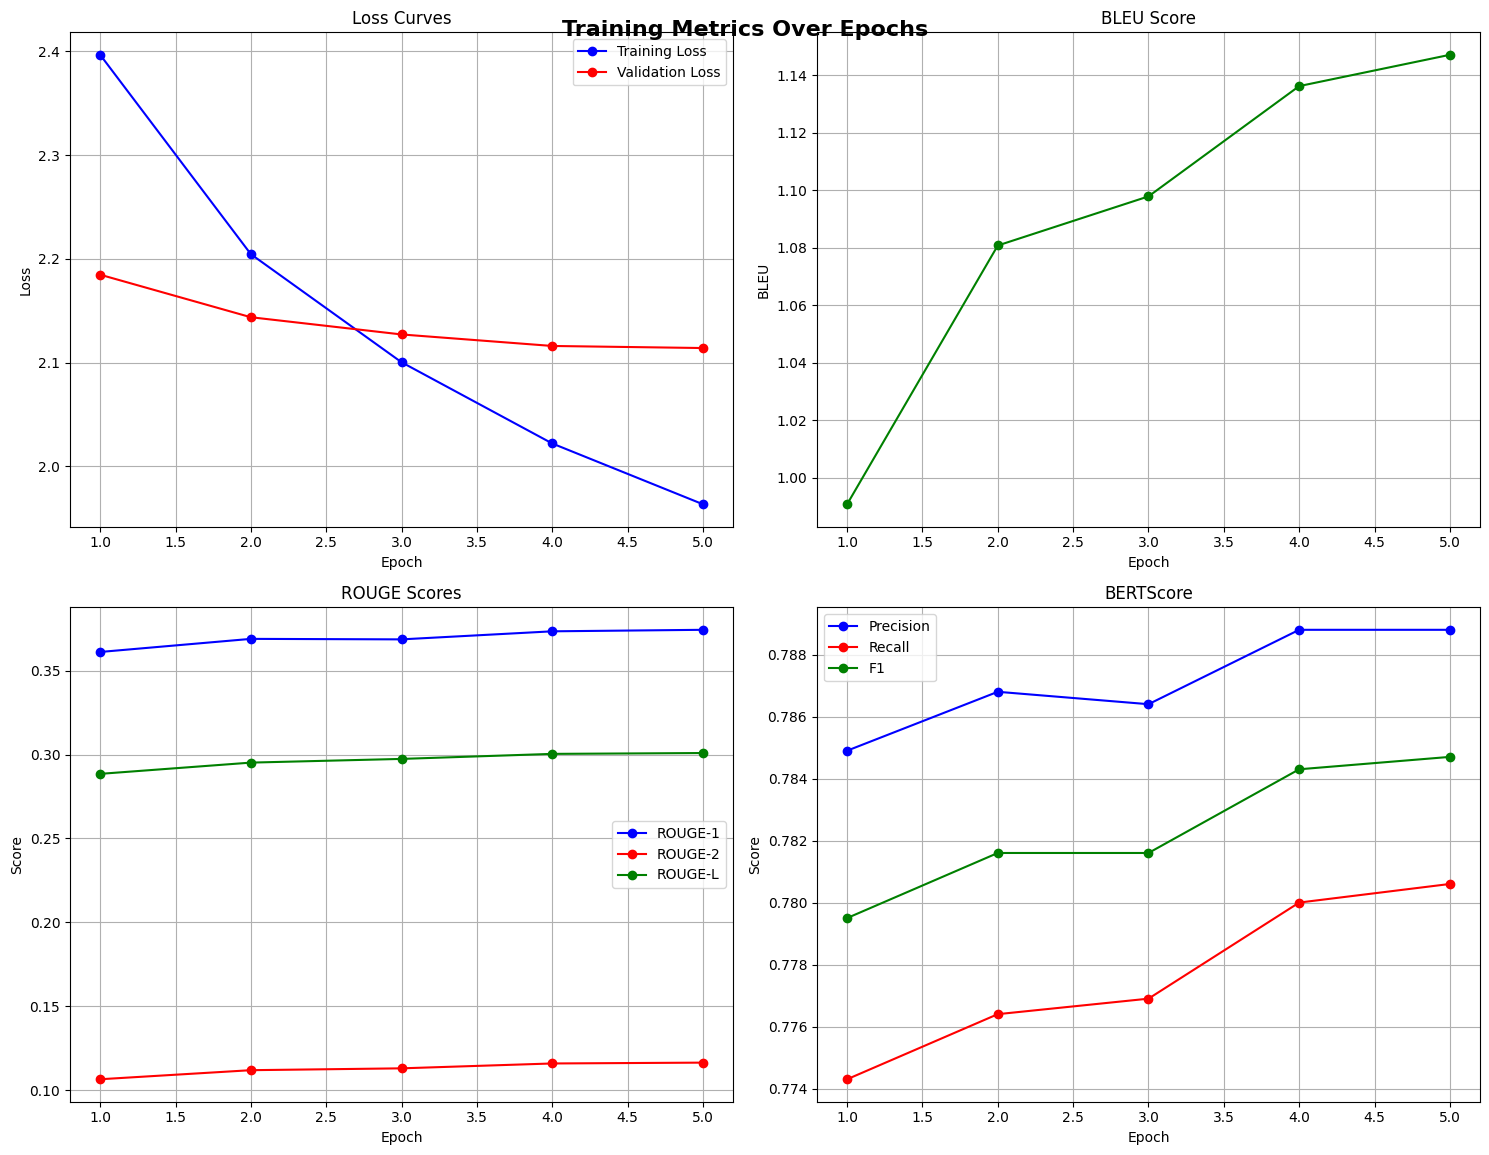

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 준비
epochs = np.arange(1, 6)
metrics = {
    'Training Loss': [2.3968, 2.2046, 2.1004, 2.0221, 1.9635],
    'Validation Loss': [2.1848, 2.1438, 2.1272, 2.1161, 2.1141],
    'BLEU': [0.9907, 1.0808, 1.0979, 1.1363, 1.1472],
    'ROUGE-1': [0.3611, 0.3689, 0.3686, 0.3734, 0.3743],
    'ROUGE-2': [0.1066, 0.1120, 0.1131, 0.1160, 0.1165],
    'ROUGE-L': [0.2885, 0.2952, 0.2974, 0.3004, 0.3009],
    'BERTScore-P': [0.7849, 0.7868, 0.7864, 0.7888, 0.7888],
    'BERTScore-R': [0.7743, 0.7764, 0.7769, 0.7800, 0.7806],
    'BERTScore-F1': [0.7795, 0.7816, 0.7816, 0.7843, 0.7847]
}

# 그래프 스타일 설정
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Training Metrics Over Epochs', size=16, weight='bold', y=0.95)

# 1. Loss 그래프
ax = axes[0,0]
ax.plot(epochs, metrics['Training Loss'], 'b-o', label='Training Loss')
ax.plot(epochs, metrics['Validation Loss'], 'r-o', label='Validation Loss')
ax.set_title('Loss Curves')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True)

# 2. BLEU 점수 그래프
ax = axes[0,1]
ax.plot(epochs, metrics['BLEU'], 'g-o')
ax.set_title('BLEU Score')
ax.set_xlabel('Epoch')
ax.set_ylabel('BLEU')
ax.grid(True)

# 3. ROUGE 점수 그래프
ax = axes[1,0]
ax.plot(epochs, metrics['ROUGE-1'], 'b-o', label='ROUGE-1')
ax.plot(epochs, metrics['ROUGE-2'], 'r-o', label='ROUGE-2')
ax.plot(epochs, metrics['ROUGE-L'], 'g-o', label='ROUGE-L')
ax.set_title('ROUGE Scores')
ax.set_xlabel('Epoch')
ax.set_ylabel('Score')
ax.legend()
ax.grid(True)

# 4. BERTScore 그래프
ax = axes[1,1]
ax.plot(epochs, metrics['BERTScore-P'], 'b-o', label='Precision')
ax.plot(epochs, metrics['BERTScore-R'], 'r-o', label='Recall')
ax.plot(epochs, metrics['BERTScore-F1'], 'g-o', label='F1')
ax.set_title('BERTScore')
ax.set_xlabel('Epoch')
ax.set_ylabel('Score')
ax.legend()
ax.grid(True)

# 레이아웃 조정
plt.tight_layout()
plt.show()